# Running experiments on a cluster

For many research projects in quantum error correction, running experiments on a computer cluster is needed to produce convincing results on large code distances. PanQEC contains an extensive set of tools to help you run experiments on a cluster painlessly. It includes commands to run experiments in parallel on a given number of cores, to generate scripts for Slurm, SGE and PBS cluster management systems, to automatically save experiments in real-time, and to check the progress of your experiments at any point.

In this tutorial, we will cover the whole pipeline of a cluster experiment, from creating the input files to plotting the final results on your laptop.

## Folder structure

In this tutorial, we will adopt the following folder structure for the experiment:

* `my-experiment/`: root folder that will contain all the data of the experiments
    * `my-experiment/inputs/`: contains the input json file(s)
    * `my-experiment/results/`: contain the result json files (once the experiments is running)
    * `my-experiment/logs/`: contain the log files of the experiment, such as the current progress and the CPU/RAM usage.
    
You can start by creating the root folder and the subfolder `inputs` on the cluster. The folders `results` and `logs` will be created automatically when starting the experiment.

## Creating the input files

PanQEC works by processing input files written in a `json` format. Those specify most details of the experiments you want to run: the code/decoder/error model to use and their parameters, the lattice sizes, the physical error rates, etc. 
Here is an example of input file that describes a 2D toric code simulation under depolarizing noise, decoded using minimum-weight perfect matching:

```json
{
    "comments": "",
    "ranges": {
        "label": "toric-2d-experiment",
        "method": {
            "name": "direct",
            "parameters": {}
        },
        "code": {
            "name": "Toric2DCode",
            "parameters": [
                {
                    "L_x": 5,
                    "L_y": 5,
                },
                {
                    "L_x": 7,
                    "L_y": 7,
                },
                {
                    "L_x": 9,
                    "L_y": 9,
                }
            ]
        },
        "error_model": {
            "name": "PauliErrorModel",
            "parameters": {
                "r_x": 0.33333333333333337,
                "r_y": 0.33333333333333337,
                "r_z": 0.3333333333333333
            }
        },
        "decoder": {
            "name": "MatchingDecoder",
            "parameters": {}
        },
        "error_rate": [
            0.1,
            0.11,
            0.12,
            0.13,
            0.14,
            0.15,
            0.16,
            0.17,
            0.18,
            0.19,
            0.2,
        ]
    }
}
```

Let's analyze the different parts of this input json file:

* `label` is a name you want to give to this experiment
* `method` specifies the simulation method. For the moment, there are two different methods: `direct` and `splitting`. The direct method consists in sampling independent errors at each Monte-Carlo round, while the splitting method samples errors using a Monte-Carlo Markov Chain algorithm introduced in [this paper](https://arxiv.org/abs/1308.6270) by Bravyi and Vargo. The splitting method has not been as thoroughly tested as the direct one in PanQEC at the moment, and we would advise against using it.
* `code`: name and parameters of the code. The list of all codes can be found using the command line `panqec ls codes`. `L_x`, `L_y` (and `L_z` for 3D codes) define the lattice dimensions.
* `error_model`: name and parameters of the error model. At the moment, there is only one error model called `PauliErrorModel`, which samples i.i.d Pauli errors at each run, without any measurement error. It is specified by three parameters, (`r_x`, `r_y`, `r_z`), which define the rate of Pauli $X$, $Y$ and $Z$ errors respectively. They should therefore all lie between $0$ and $1$ and satisfy the constraint $r_x+r_y+r_z=1$.
* `decoder`: name and parameters of the decoder. The list of all decoders can be found using the command line `panqec ls decoders`.
* `error_rate`: list of physical error rates included in the simulation.

To create your own input, you can either copy-paste the one above in a file `my-experiment/inputs/experiment.json`, or generate it using the `panqec` command `generate-input`:

```bash
panqec generate-input -d "my-experiment" \
    --code_class Toric2DCode --sizes "5x5,7x7,9x9" \
    --decoder_class MatchingDecoder \
    --bias "Z" --eta "0.5" \
    --prob "0.1:0.2:0.01"
```

The only non-obvious parameters might be `bias` and `eta`. The parameter `bias` can be either `X`, `Y` or `Z`, and `eta` can be any value between `0.5` and `inf`, where `eta=0.5` corresponds to depolarizing noise and `eta=inf` to pure {X,Y,Z} noise (depending on the value of `bias`). See `panqec generate-input --help` for more information.

To test that input file is correct and that all the libraries are correctly installed, we recommand you to do a mock run with the following command:

```bash
panqec run -i my-experiment/inputs/input.json -o mock.json.gz -t 10
```

This will run your experiment with 10 trials and store the result in a compressed json file `mock.json.gz`

## Generating and cluster script

PanQEC has a command to automatically generate a cluster script, namely `panqec generate-cluster-script`. Its first input is a *header file*. It contains the first few lines of your cluster scripts, which are often cluster-specific. Here is an example of header file for Slurm: (Note that your cluster may require slightly a slightly different format)

```bash
#!/bin/bash
#SBATCH -N 1
#SBATCH -t ${TIME}
#SBATCH --cpus-per-task=${N_CORES}
#SBATCH --exclusive
#SBATCH --job-name=${NAME}
#SBATCH --array=1-${N_NODES}
#SBATCH --mem=${MEMORY}
#SBATCH -p ${QUEUE}
#SBATCH --output=${DATA_DIR}/%j.out

module purge
module load gcc/devtoolset/9
module load anaconda/anaconda3.7
source ~/.bashrc
```

All the variables enclosed by `${}` will be replaced by an actual value in the final cluster script. 
Once you have this header ready, let's say in a file `~/slurm-header.sbatch`, you can run the following command:

```bash
panqec generate-cluster-script \
       ~/slurm_header.sbatch \
       --output-file my-experiment/run.sbatch \
       --data-dir my-experiment \
       --cluster slurm \
       --trials 10000 \
       --n-nodes 8 \
       --n-cores 5 \
       --wall-time "00:10:00" \
       --memory "1G" \
       --delete-existing
```

You should now have the following content in `my-experiment/run.sbatch`:

```bash
#!/bin/bash
#SBATCH -N 1
#SBATCH -t 00:10:00
#SBATCH --cpus-per-task=30
#SBATCH --exclusive
#SBATCH --job-name=my-experiment
#SBATCH --array=1-10
#SBATCH --mem=1G
#SBATCH -p pml
#SBATCH --output=my-experiment/%j.out

module purge
module load gcc/devtoolset/9
module load anaconda/anaconda3.7
source ~/.bashrc

panqec monitor-usage my-experiment/logs/usage_$SLURM_JOB_ID_$SLURM_ARRAY_TASK_ID.txt &

panqec run-parallel -d my-experiment -n 8 -j $SLURM_ARRAY_TASK_ID -c 5 -t 10000 --delete-existing

date
```

As you can see, it first contains a command to monitor the usage (CPU and RAM), which will be stored in the logs directory. The second command, `run-parallel`, parallelizes the 1000 Monte Carlo trials over all the nodes and cores, and runs the simulation on the current node of the job array.

## Running the script and checking progress

Simply run the script generated above with your cluster system command. For instance, for Slurm, enter:

```bash
sbatch my-experiment/run.sbatch
```

You can check the progress of the experiment with the command

```bash
panqec check-progress my-experiments/logs
```

You can add the option `-a` to inspect the progress on all the cores individually

## Aggregating and analyzing results

Once the experiment is running, all the results will be regularly saved in the files `my-experiments/results/results_[i].json.gz` where `[i]` is the index of the core. At any moment during the experiment, you can merge the results into a single file and send it to your laptop for analysis. Here is the command you need to run:

```bash
panqec merge-results my-experiments/results/results_* -o my-experiments/merged-results.json.gz
```

You can then send the file `my-experiments/merged-results.json.gz` to your laptop using `scp`, `rsync` or an equivalent method. 

The following piece of code, that you can run on a Jupyter Notebook locally, will allow you to quickly visualize the obtained data:

Finding files
Found 1 files
Reading files
Aggregating data
Calculating total error rates
Calculating word error rates
Calculating single qubit error rates


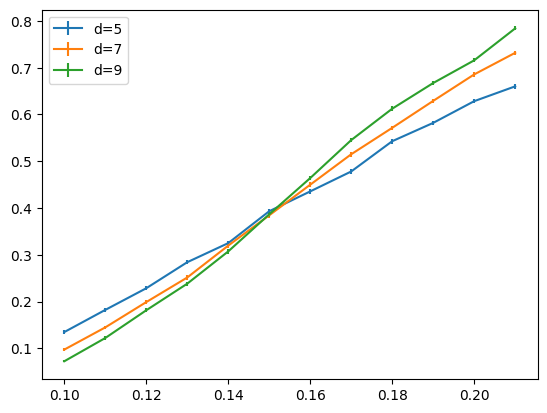

In [43]:
from panqec.analysis import Analysis
import matplotlib.pyplot as plt

analysis = Analysis("my-experiment/merged-results.json.gz")
results = analysis.get_results()

for d in results['d'].unique():
    plt.errorbar(results[results['d'] == d]['error_rate'], 
                 results[results['d'] == d]['p_est'],
                 results[results['d'] == d]['p_se'],
                 label=f'd={d}')

plt.legend()